#### **Лабораторная №1. Отбор признаков**
Шкуратова Д.В. Группа: Б9122-01.03.02мкт

## Import

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from IPython.display import display

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [33]:
from itertools import combinations

## Dataset
Датасет взят с сайта [hugginface](https://huggingface.co/datasets/mnemoraorg/calorie-burnt-15k)

**(raw_exercise.csv):**
- User_ID: Уникальный id человека
- Gender: пол
- Age: Возраст
- Height: Рост в см
- Weight: Вес в кг
- Duration: Продолжительность тренировки в минутах
- Heart_Rate: Пулльс удар./с 
- Body_Temp: Температура тела, измеренная во время или после тренеровки в $^oC$.

**(raw_calories.csv):**

- User_ID: ref user_id.
- Calories: потраченные калории за тренировку

In [34]:
df_ex = pd.read_csv("hf://datasets/mnemoraorg/calorie-burnt-15k/raw_exercise.csv")
df_cal = pd.read_csv("hf://datasets/mnemoraorg/calorie-burnt-15k/raw_calories.csv")
df = df_ex.merge(df_cal, on='User_ID')
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


## Статистика

#### Пропуски

In [35]:
df.isna().sum().sort_values(ascending=False)

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [36]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


## Распределение признаков


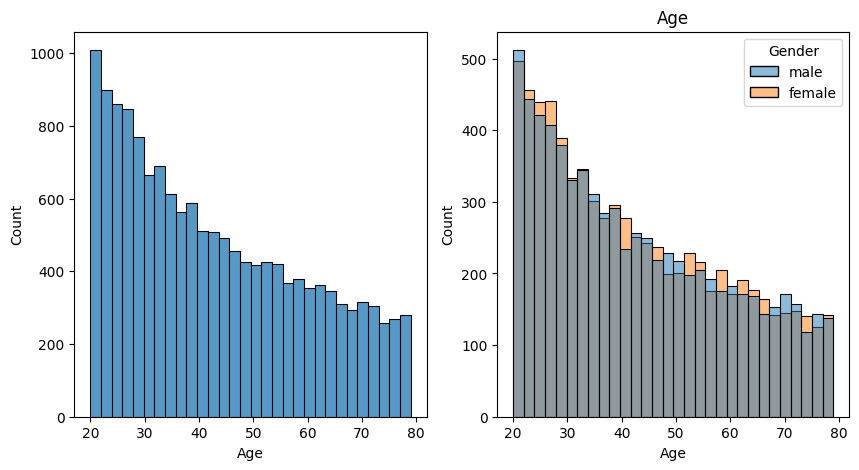

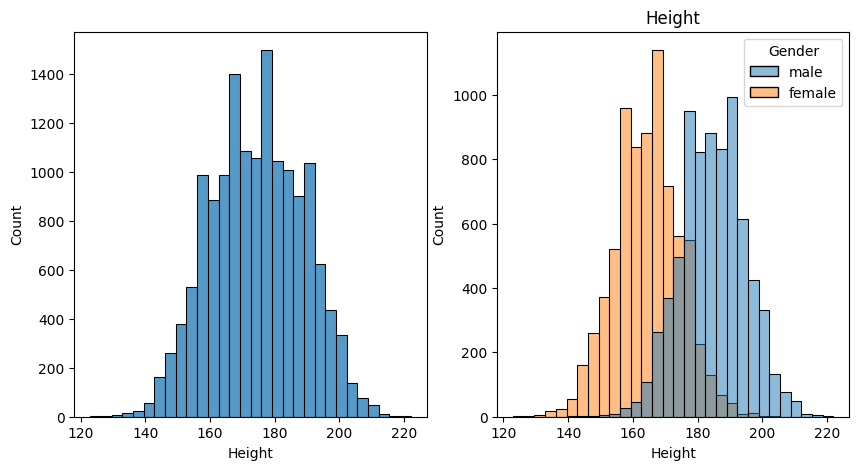

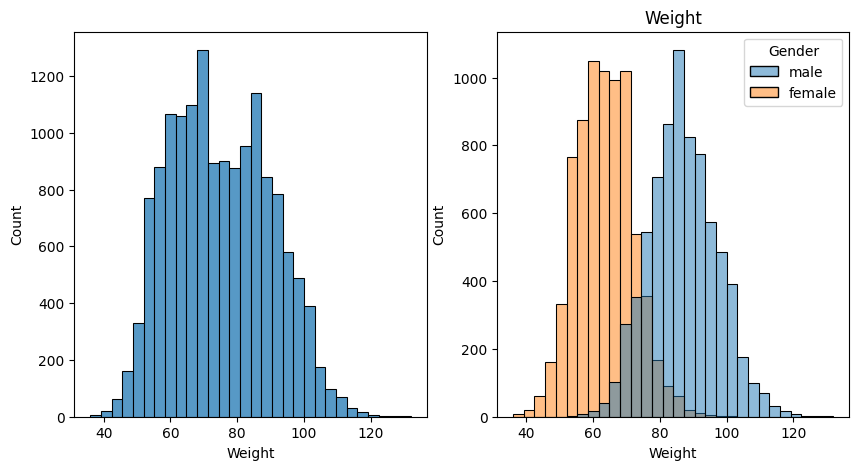

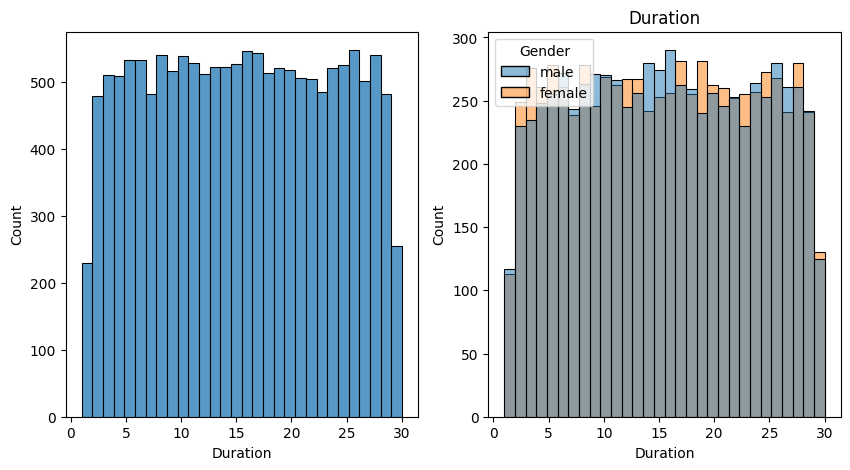

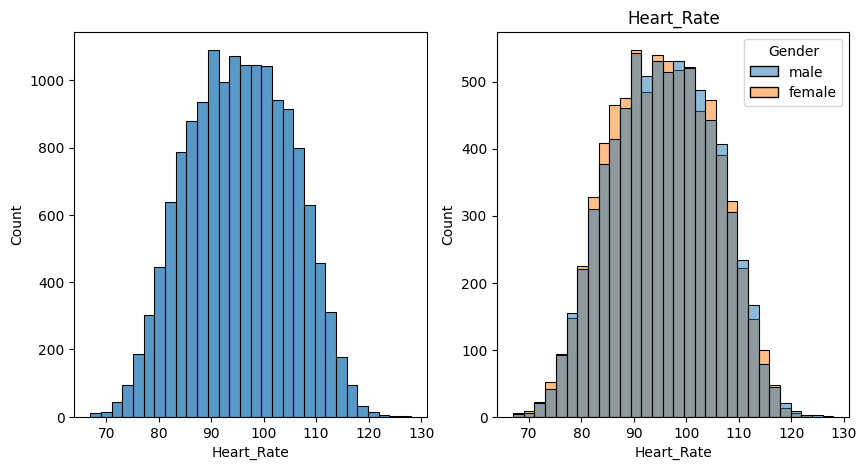

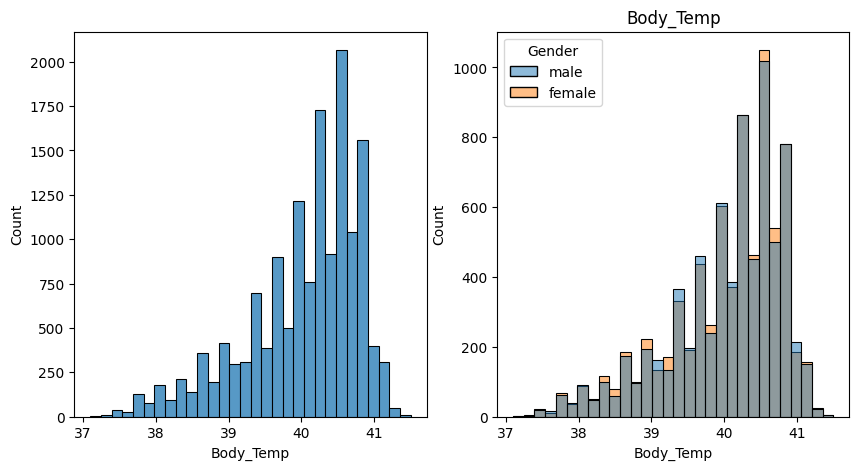

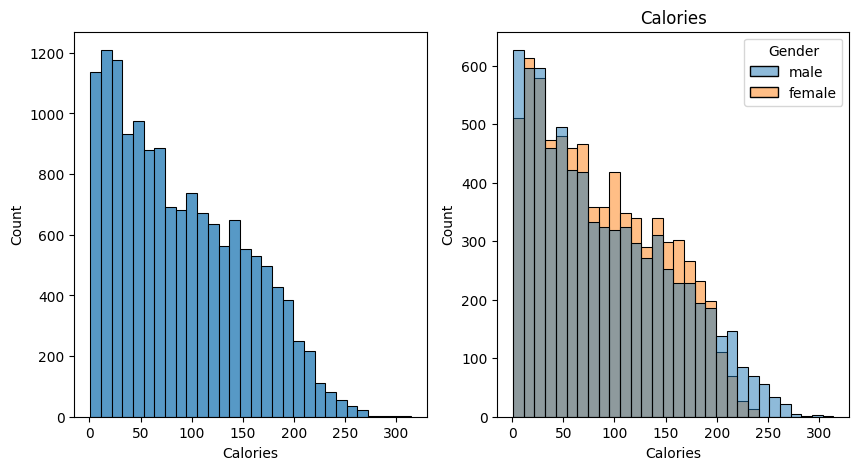

In [37]:
features = df.columns.drop(['User_ID', 'Gender'])
for feature in features:
    fig, ax = plt.subplots(1, 2,  figsize=(10, 5))
    sns.histplot(df, x=feature, label='all', ax=ax[0], bins=30)
    sns.histplot(df, x=feature, hue='Gender', ax=ax[1], bins=30)
    plt.title(feature)
    plt.show()

По распределениям признаков видим, что вес, рост и пульс близки к нормальному.

Распределения с группировкой по полу отличаются только для признаков рост и вес

## Проверка на выбросы
Проверим рост на выбросы: по таблице с минимальным значеним, 1-му, 3-му квартилю и графику распределения видим возможные выбросы 

### Height

<Axes: xlabel='Height'>

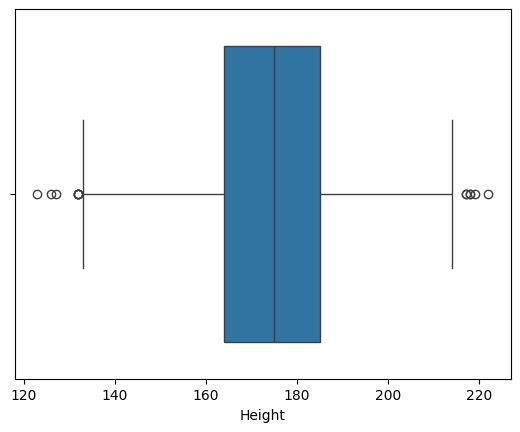

In [38]:
sns.boxplot(df, x='Height')

In [39]:
Q1 = df['Height'].quantile(0.25)
Q3 = df['Height'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df['Height'] < lower_bound) | (df['Height'] > upper_bound)]

display(pd.Series([Q1, Q3, IQR, lower_bound, upper_bound, len(outliers_iqr)],
    index=['Q1', 'Q3', 'IQR', 'Нижняя граница', 'Верхняя граница', 'Количество выбросов']))

print("Выбросы:")
display(outliers_iqr.sort_values('Height'))

Q1                     164.0
Q3                     185.0
IQR                     21.0
Нижняя граница         132.5
Верхняя граница        216.5
Количество выбросов     14.0
dtype: float64

Выбросы:


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
4200,17172665,female,63,123.0,40.0,9.0,97.0,39.9,55.0
7774,18699424,female,30,126.0,39.0,25.0,104.0,40.7,156.0
6226,11581936,female,58,127.0,40.0,29.0,102.0,40.8,189.0
529,13721168,female,35,132.0,38.0,30.0,112.0,40.5,216.0
4855,10647581,female,59,132.0,40.0,10.0,92.0,39.9,55.0
4404,11352685,female,20,132.0,41.0,5.0,85.0,39.3,20.0
13100,17972006,female,51,132.0,41.0,6.0,86.0,39.2,28.0
8931,11308308,female,26,132.0,36.0,5.0,91.0,39.2,24.0
13276,13066276,male,55,217.0,126.0,17.0,91.0,40.4,101.0
1464,18787703,male,51,217.0,118.0,4.0,85.0,39.1,19.0


Удалим  14 строк с выбросами, для датасета размером 15_000 это небольшой набор записей 

<Axes: xlabel='Height'>

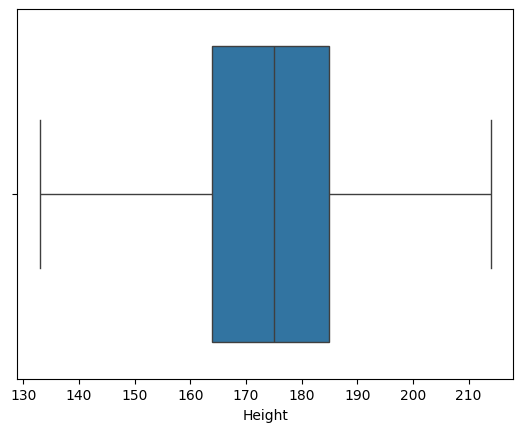

In [40]:
df = df[(df['Height'] > lower_bound) &  (df['Height'] < upper_bound)]
sns.boxplot(df, x='Height')

In [41]:
df['Height'].describe()

count    14986.000000
mean       174.471507
std         14.199316
min        133.000000
25%        164.000000
50%        175.000000
75%        185.000000
max        214.000000
Name: Height, dtype: float64

Преобразуем Gender к бинарной переменной 

In [42]:
df['gender_bin'] = df['Gender'].map({'male':1, 'female':0})

## Корреляция между признаками


<Axes: >

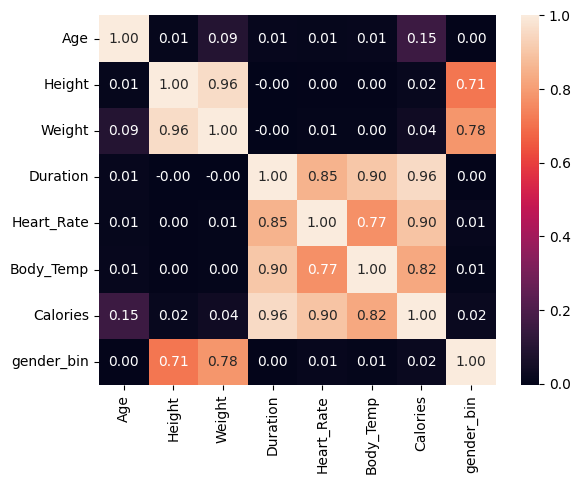

In [43]:
sns.heatmap(df.loc[:, 'Age':].corr(numeric_only=True), 
            annot=True, 
            fmt='.2f')

**Корреляция с целевой переменной:**
- Duration, Heart_Rate, Body_Temp имеет очень высокий положительный коэффициент корреляции с целевой переменной, при этом попарно между собой они также сильно коррелируют: можем из них оставить только Duration, т.к. он имеет наибольшую корреляцию с целевой переменной
- С остальными признаками: Height, Weight, Age корреляция почти нулевая 
- Корреляция между Height и Weight = 0.96, можем либо удалить один из них, либо преобразовать к индексу массы тела


## Выбор модели для оценки признаков

Построим  линейную модель и дерево решений (глубины 6) для задачи регрессии. Выбрем наилучшую из них для дальнейшей оценки точности на разных подмножествах признаков.

Перед обучением разделим выброку на тренировочную, валидационную и тестовую  

In [46]:
X = df.columns.drop(['User_ID', 'Gender', 'Calories'])
target = 'Calories'
train, valid = train_test_split(df, train_size=0.7, random_state=76513)
valid, test = train_test_split(valid, train_size=0.5, random_state=97645)

X_train = train[X]
y_train = train[target]

X_valid = valid[X]
y_valid = valid[target]

X_test = test[X]
y_test = test[target]

lm = LinearRegression()

lm.fit(X_train, y_train)

RANDOM_STATE = 57523
dt = DecisionTreeRegressor(max_depth=6, criterion='squared_error', random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,57523
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [47]:
def get_metric(y_true, y_pred, model_name, subset='train'):
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return pd.DataFrame({
        'MSE': [mse],
        'RMSE': [mse  ** (1 / 2)],
        'MAE': [mae],
        'R2': [r2]
    }, index=[f'{model_name}_{subset}'])

model_metrics = pd.concat([
    get_metric(y_train, lm.predict(X_train), 'LinReg', 'train'),
    get_metric(y_valid, lm.predict(X_valid), 'LinReg', 'valid'),
    get_metric(y_test, lm.predict(X_test), 'LinReg', 'test'),
    
    get_metric(y_train, dt.predict(X_train), 'DT', 'train'),
    get_metric(y_valid, dt.predict(X_valid), 'DT', 'valid'),
    get_metric(y_test, dt.predict(X_test), 'DT', 'test'),
])
model_metrics

,MSE,RMSE,MAE,R2
LinReg_train,128.782407,11.348234,8.376644,0.967037
LinReg_valid,131.362214,11.461336,8.462665,0.965534
LinReg_test,120.851566,10.993251,8.156444,0.969452
DT_train,91.909486,9.586944,6.862928,0.976475
DT_valid,110.726181,10.522651,7.598613,0.970948
DT_test,100.824793,10.041155,7.218830,0.974514


Обе модели хорошо предсказывают целевую переменную (коэффициент детерминации $R^2$ > 0.95 для обеих моделей на всех подвыборках), но средняя ошибка  ниже для дерева решения.

Проверим распределение предсказанных и истинных значений с помощью графиков

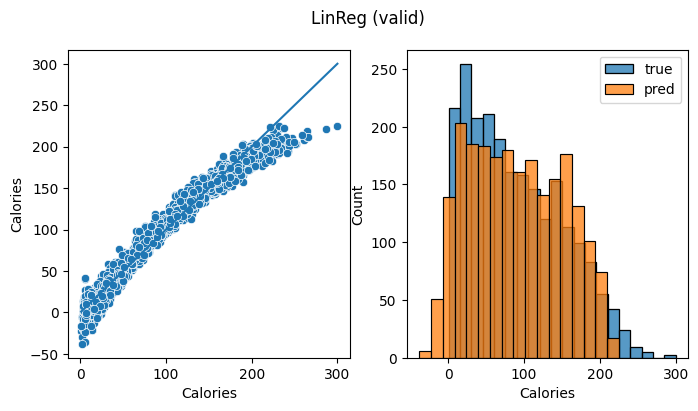

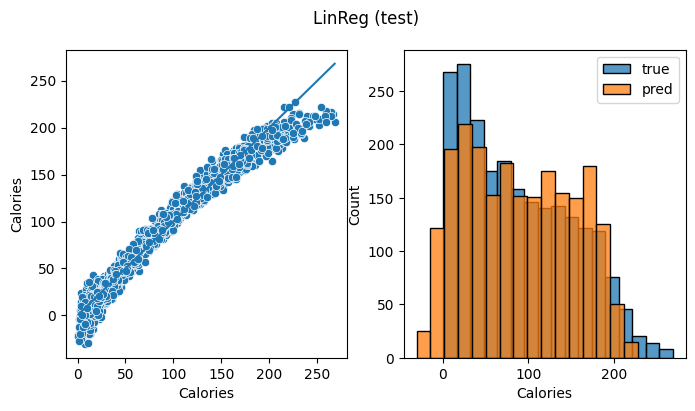

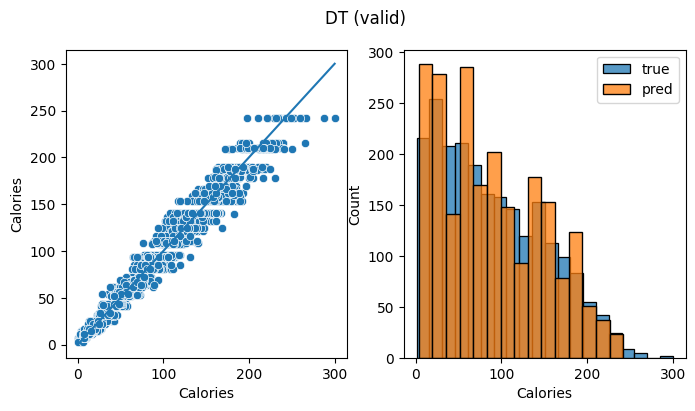

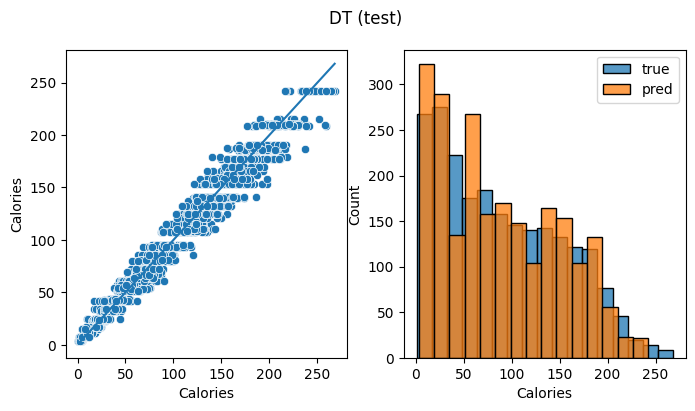

In [48]:
def pred_plot(y_true, y_pred, model_name):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    sns.scatterplot(x=y_true, y=y_pred, ax=ax[0])
    sns.lineplot(x=y_true, y=y_true, ax=ax[0])
    sns.histplot(x=y_true, label='true', ax=ax[1])
    sns.histplot(x=y_pred, label='pred', ax=ax[1])
    fig.suptitle(model_name)
    plt.legend()
    plt.show()

pred_plot(y_valid, lm.predict(X_valid), 'LinReg (valid)')
pred_plot(y_test, lm.predict(X_test), 'LinReg (test)')
pred_plot(y_valid, dt.predict(X_valid), 'DT (valid)')
pred_plot(y_test, dt.predict(X_test), 'DT (test)')


В первой колонке графиков по оси X отмечены истинные значения, по оси Y- предсказанные, чем ближе этот график к прямой, тем меньше ошибка модели.
Во второй отображено распределение предсказанных и истинных значений, чтобы проверить какие значения выдает модель.

Для линейной модели получили отрицательные значения переменной.

In [49]:
print(f'LinReg[Calories < 0]: {(lm.predict(df[X]) < 0).astype(int).sum()}')

LinReg[Calories < 0]: 729


### Feature Importance

Выведем коэффициенты при признаках для линейно модели и feature_imortance для дерева решений

In [50]:
fi = pd.DataFrame({
    'feature': X,
    'lm_coef':lm.coef_,
    'dt_importance':dt.feature_importances_
})
fi.sort_values('dt_importance', ascending=False).round(4)

,feature,lm_coef,dt_importance
3,Duration,6.6318,0.9329
4,Heart_Rate,1.9953,0.0393
0,Age,0.5030,0.0214
6,gender_bin,-1.2957,0.0063
2,Weight,0.2940,0.0001
1,Height,-0.1691,0.0000
5,Body_Temp,-16.8569,0.0000


In [51]:
print(f'Intercept:{lm.intercept_}')

Intercept:457.17863343543854


- Для обеих моделей получили, что наибольший вклад вносит Duration
- Height и Body_Temp для дерева решений имеет feature_imoportance = 0
- Для линейной модели свободный член (Intercept) принял слишком большое значение относительно диапазона значений целевой переменной 

## Отбор признаков

### Преобразование выоскокоррелированных признаков
- Преобразуем Height И Weight к индексу массы тела (BMI)
- Удалим из выборки Body_Temp и Heart_Rate, т.к. эти признаки высоко коррелируют с Duration

In [52]:
df.columns

Index(['User_ID', 'Gender', 'Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp', 'Calories', 'gender_bin'],
      dtype='object')

In [53]:
train['BMI'] = train['Weight'] / (train['Height']) ** 2
valid['BMI'] = valid['Weight'] / (valid['Height']) ** 2
test['BMI'] = test['Weight'] / (test['Height']) ** 2
X1 = X.drop(['Weight', 'Height', 'Body_Temp', 'Heart_Rate'])
X1 =X1.union(pd.Index(['BMI']))
X1

Index(['Age', 'BMI', 'Duration', 'gender_bin'], dtype='object')

### Жадный алгоритм
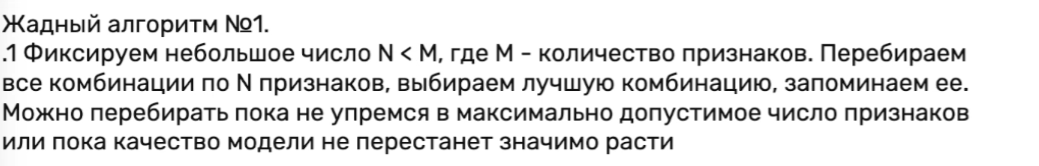

Жадный алгоритм будем тестировать на двух датасетах, т.к. признаков не очень много в первом 7, во втором - 4.

Можем выбрать $N=1$. 
Всего придется перебрать $2^7$ вариантов в первом случа и $2^4$ во втором.

Замерять точность будем на валидационной выборке

In [59]:
def greed_feature_selection(train, valid,  columns, target):
    subsets = [list(comb) for i in range(1, columns.size +1) for comb in combinations(columns, i)]
    metrics = []
    for i, subset in enumerate(subsets):
        dt = DecisionTreeRegressor(max_depth=6, criterion='squared_error', random_state=RANDOM_STATE)
        X_train = train[subset]
        y_train = train[target]
        X_valid = valid[subset]
        y_valid = valid[target]

        dt.fit(X_train, y_train)
        metrics.append(get_metric(y_valid, dt.predict(X_valid), f'DT_{i + 1}', 'valid'))
    metrics = pd.concat(metrics)
    metrics['feature_list'] = subsets
    metrics['feature_cnt'] = [len(subset) for subset in subsets]
    return metrics.round(6)

In [60]:
greed_res = greed_feature_selection(train, valid,  X, target)
greed_res.sort_values('MAE')

,MSE,RMSE,MAE,R2,feature_list,feature_cnt
DT_113_valid,110.447836,10.509417,7.587408,0.971021,"[Age, Duration, Heart_Rate, Body_Temp, gender_...",5
DT_81_valid,110.447836,10.509417,7.587408,0.971021,"[Age, Duration, Heart_Rate, gender_bin]",4
DT_124_valid,110.627987,10.517984,7.595362,0.970974,"[Age, Height, Duration, Heart_Rate, Body_Temp,...",6
DT_106_valid,110.627987,10.517984,7.595362,0.970974,"[Age, Height, Duration, Heart_Rate, gender_bin]",5
DT_127_valid,110.726181,10.522651,7.598613,0.970948,"[Age, Height, Weight, Duration, Heart_Rate, Bo...",7
...,...,...,...,...,...,...
DT_2_valid,3828.954221,61.878544,52.313718,-0.004629,[Height],1
DT_3_valid,3838.560321,61.956116,52.360694,-0.007149,[Weight],1
DT_47_valid,3857.299356,62.107160,52.384369,-0.012066,"[Height, Weight, gender_bin]",3
DT_22_valid,3838.076128,61.952208,52.410684,-0.007022,"[Weight, gender_bin]",2


In [61]:
pd.concat([greed_res[['MSE', 'MAE']].idxmin(), greed_res[['R2']].idxmax()])

MSE    DT_81_valid
MAE    DT_81_valid
R2     DT_81_valid
dtype: object

In [62]:
greed_res_2 = greed_feature_selection(train, valid,  X1, target)
greed_res_2.sort_values('MAE')

,MSE,RMSE,MAE,R2,feature_list,feature_cnt
DT_13_valid,184.798081,13.594046,9.576453,0.951513,"[Age, Duration, gender_bin]",3
DT_15_valid,184.798081,13.594046,9.576453,0.951513,"[Age, BMI, Duration, gender_bin]",4
DT_11_valid,205.891186,14.348909,9.998327,0.945979,"[Age, BMI, Duration]",3
DT_6_valid,207.688967,14.411418,10.038901,0.945507,"[Age, Duration]",2
DT_14_valid,276.723625,16.635012,11.552203,0.927394,"[BMI, Duration, gender_bin]",3
DT_8_valid,275.887974,16.609876,11.562224,0.927613,"[BMI, Duration]",2
DT_10_valid,284.760468,16.874847,11.666118,0.925285,"[Duration, gender_bin]",2
DT_3_valid,293.143406,17.121431,11.763561,0.923086,[Duration],1
DT_7_valid,3715.647146,60.956108,51.416541,0.025100,"[Age, gender_bin]",2
DT_1_valid,3703.742578,60.858381,51.443303,0.028224,[Age],1


In [63]:
pd.concat([greed_res_2[['MSE', 'MAE']].idxmin(), greed_res_2[['R2']].idxmax()])

MSE    DT_13_valid
MAE    DT_13_valid
R2     DT_13_valid
dtype: object

## Метрики на лучшем подмножестве
Переобучим дерево на лучшем подмножестве посчитаем метрики и посмотрим на графики распределения

In [64]:
best_subset = greed_res.loc[greed_res['MSE'].idxmin()]['feature_list']
dt = DecisionTreeRegressor(max_depth=5, criterion='squared_error', random_state=RANDOM_STATE)

dt.fit(train[best_subset], train[target])

,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,57523
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [65]:
bs_metrics = pd.concat([
    get_metric(y_train, dt.predict(train[best_subset]), 'DT', 'train'),
    get_metric(y_valid, dt.predict(valid[best_subset]), 'DT', 'valid'),
    get_metric(y_test, dt.predict(test[best_subset]), 'DT', 'test'),
])
bs_metrics

,MSE,RMSE,MAE,R2
DT_train,137.382256,11.721018,8.496170,0.964836
DT_valid,161.534494,12.709622,9.201885,0.957617
DT_test,147.262698,12.135184,8.842828,0.962776


После перебора всевозможных подмножеств не удалось сильно снизить RMSE и MAE по сравнению с первым запуском моделей, но получили, что можно снизить размерность с 7 до 4 признаков. 

Проверим графики и выведем feature importance

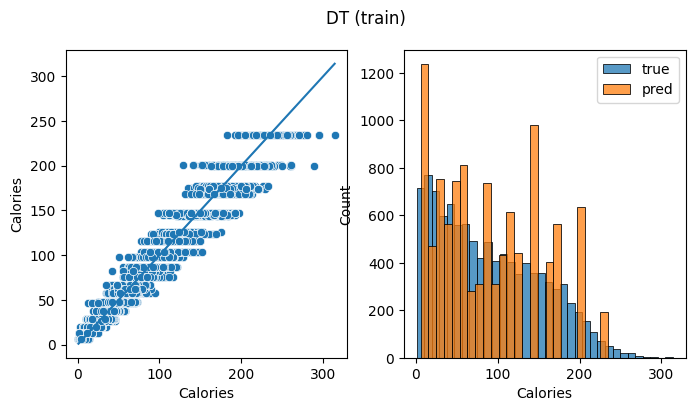

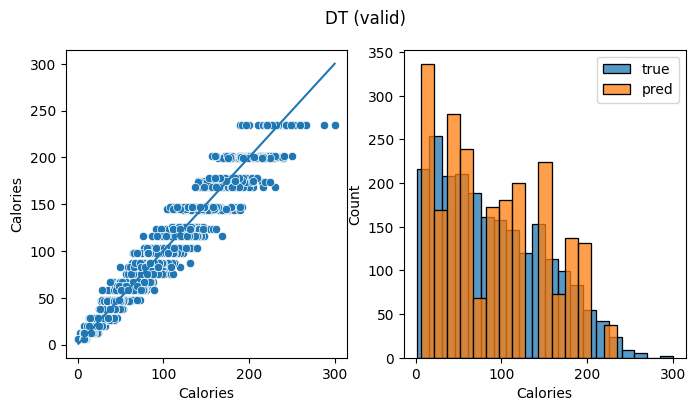

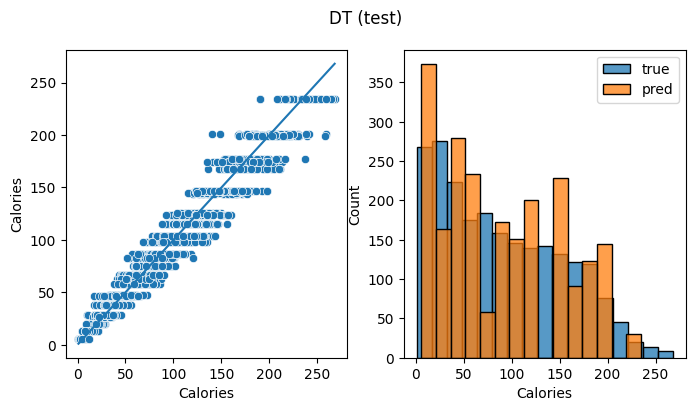

In [66]:
pred_plot(y_train, dt.predict(train[best_subset]), 'DT (train)')
pred_plot(y_valid, dt.predict(valid[best_subset]), 'DT (valid)')
pred_plot(y_test, dt.predict(test[best_subset]), 'DT (test)')

### Feature Importance best subset

In [67]:
pd.DataFrame({
    'feature':best_subset,
    'dt_importance':dt.feature_importances_
}).sort_values('dt_importance', ascending=False)

,feature,dt_importance
1,Duration,0.938630
2,Heart_Rate,0.036680
0,Age,0.020558
3,gender_bin,0.004133


В итоговом наборе признаков получиили первые 4 после сортировки по feature importance при первом обучении дерева решений на всем множестве признаков